<center><font size ="9"> PROJECT 02</font></center>
<center><font size ="6"> LOGISTIC REGRESSION</font></center></br>
<font size ="4"> THÔNG TIN NHÓM:</font>

18120492 - Du Chí Nhân

18120496 - Lê Hoàng Phương Nhi

18120529 - Phan Văn Võ Quyền

18120530 - Lê Thị Như Quỳnh

18120540 - Phạm Minh Sỹ


# Import

In [1]:
import numpy as np
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from seaborn import heatmap
import pandas as pd
import tensorflow.keras.datasets.mnist as mnist

import tkinter as tk
import cv2
from PIL import ImageDraw, Image

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
(X, y), (X_test, y_test) = mnist.load_data()
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# Explore data

In [3]:
pixel_cols = np.vstack((X, X_test))
label_col = np.hstack((y, y_test))

In [4]:
pixel_cols = pixel_cols.reshape((-1,28*28))
df = pd.DataFrame(pixel_cols,label_col)
df.index.name = 'label'
df.reset_index(inplace=True)

In [5]:
X_df = df.drop('label',axis=1)
y_df = df['label']
y_df_encoded = pd.get_dummies(y_df,prefix='label')

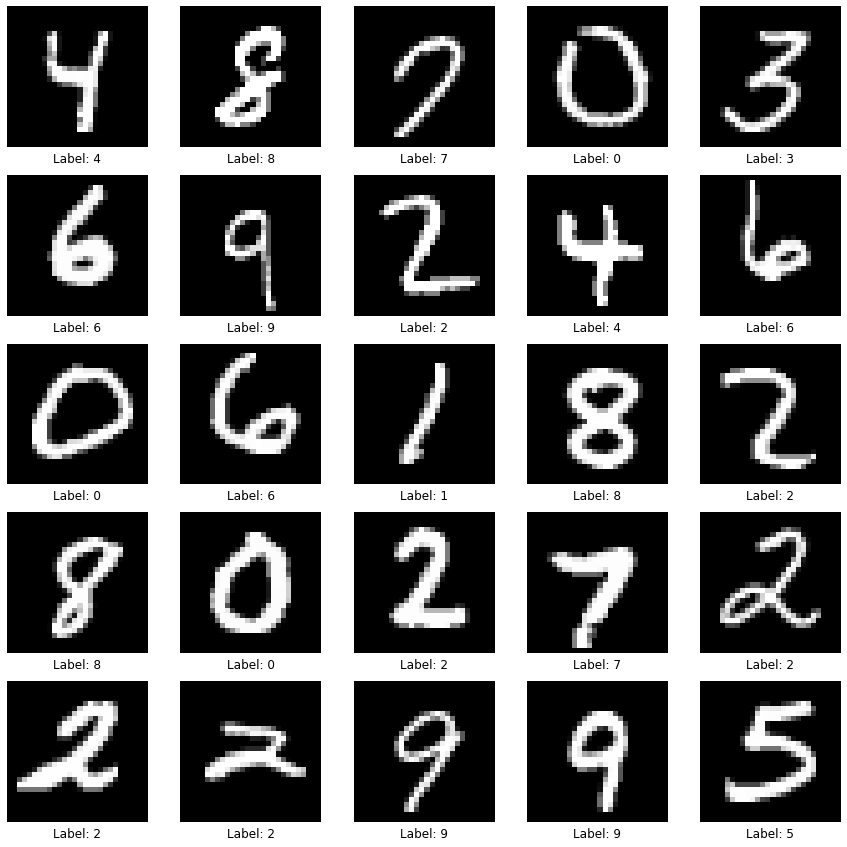

In [6]:
np.random.seed(26)
rand_arr = np.random.choice(len(df),size=25,replace=False)
fig, axs = plt.subplots(5,5,figsize=(15,15))
j = 0
for i in rand_arr:
    ax = axs[j//5 , j%5]
    ax.imshow((X_df.iloc[i].values).reshape(28,28),cmap='gray')
    ax.axis('off')
    ax.set_title('Label: {}'.format(y_df.iloc[i]),fontsize=12,y=-0.15)
    j += 1
plt.show()

# Preprocessing

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 1/6, random_state=0, stratify=y)

In [8]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

## Labels

In [9]:
def output_preprocessing(y_train):
  y_train_preprocessed = pd.get_dummies(y_train)
  return y_train_preprocessed

In [10]:
y_train_preprocessed = output_preprocessing(y_train)

## Meanless Pixels Dropping

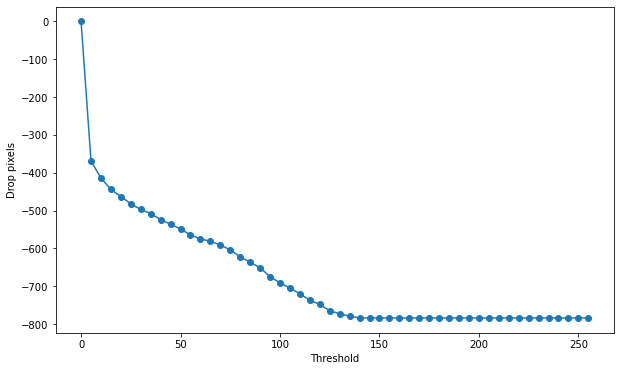

In [11]:
fig, axs = plt.subplots(figsize=(10,6))
ks = range(0,256,5)
drop_pix = []
for k in ks:
    drop_pix.append(-(X_train.mean(axis=0) < k).sum())
axs.plot(ks,drop_pix,'o-')
axs.set_xlabel('Threshold')
axs.set_ylabel('Drop pixels')
plt.show()

In [12]:
print('We will drop {} pixels'.format((X_train.mean(axis=0) <= 1).sum()))
dropidx = np.argwhere(X_train.mean(axis=0) <= 1).reshape(-1)

We will drop 283 pixels


In [13]:
class Meanless_Pix_Dropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1):
        self.threshold = threshold

    def fit(self, X, y=None):
        self.drop_idx = np.argwhere(X.mean(axis=0) <= self.threshold).reshape(-1)
        return self

    def transform(self, X, y=None):
        return np.delete(X, self.drop_idx, axis=1)

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self,param,value)
        return self

## Multicollinearity
- Đa cộng tuyến là hiện tượng các biến độc lập trong mô hình hồi qui phụ thuộc tuyến tính lẫn nhau, thể hiện dưới dạng hàm số (vi phạm giả định 5 của mô hình hồi qui tuyến tính).
- Mặc dù sự hiện diện của đa cộng tuyến không ảnh hưởng đến tính nhất quán của các ước tính OLS của các hệ số hồi qui. Tuy nhiên, các ước tính sẽ trở nên không chính xác và không đáng tin cậy.
- Dưới đây sẽ sử dụng PCA để xử lý hiện tượng đa cộng tuyến.
- PCA là một thủ tục thống kê (statistical procedure) biến đổi một tập các biến tương quan thành một tập hợp các biến ít/không tương quan được gọi là thành phần chính. PCA loại bỏ đa cộng tuyến bằng cách chuyển đổi các feature ban đầu thành các feature có hiệu suất cao hơn với ít nhiễu hơn.

In [14]:
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     111.2
Date:                Sat, 26 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:31:49   Log-Likelihood:            -1.0004e+05
No. Observations:               50000   AIC:                         2.015e+05
Df Residuals:                   49287   BIC:                         2.078e+05
Df Model:                         712                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9718      0.035     84.875      0.0

- Dữ liệu ban đầu có R_squared = 0.616, nên chúng ta đặt nghi vấn đã xảy ra đa cộng tuyến (R_squared càng cao và càng gần 1 thì mối quan hệ phụ thuộc giữa các features càng lớn)

In [15]:
pca1 = PCA(n_components = .98)

In [16]:
tmp_X = X_train
tmp_X = pca1.fit_transform(tmp_X)

In [17]:
results = sm.OLS(y_train, sm.add_constant(tmp_X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     294.7
Date:                Sat, 26 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:31:58   Log-Likelihood:            -1.0063e+05
No. Observations:               50000   AIC:                         2.018e+05
Df Residuals:                   49738   BIC:                         2.041e+05
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4539      0.008    548.629      0.0

- Sử dụng pca1(n_components=0.98), R_squared giảm xuống còn 0.606

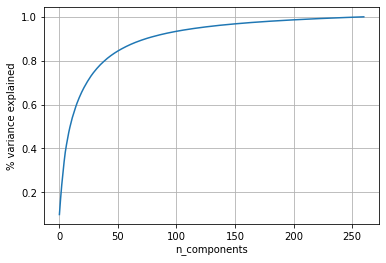

In [18]:
percent_var_explained = pca1.explained_variance_/(np.sum(pca1.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [19]:
pca2 = PCA(n_components = 40, random_state=1)

In [20]:
tmp_X = X_train
tmp_X = pca2.fit_transform(tmp_X)

In [21]:
results = sm.OLS(y_train, sm.add_constant(tmp_X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     1439.
Date:                Sat, 26 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:32:04   Log-Likelihood:            -1.0483e+05
No. Observations:               50000   AIC:                         2.098e+05
Df Residuals:                   49959   BIC:                         2.101e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4539      0.009    505.485      0.0

- Sử dụng pca2(n_components=40, random_state=1) thu được R_squared = 0.535

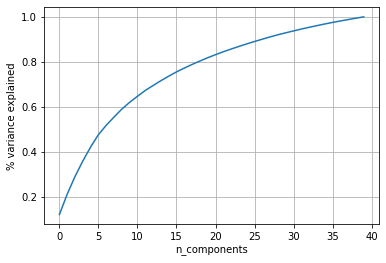

In [22]:
percent_var_explained = pca2.explained_variance_/(np.sum(pca2.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

# Build model

In [23]:
ovr_classifiers = []
for col in y_train_preprocessed:
    ovr_classifiers.append(LogisticRegression(max_iter = 200))

## Utilities

In [24]:
def predictions(models,test_X):

    preds_y = []
    
    for model in models:
        ## chọn xác suất thuôc về  lớp
        y = model.predict_proba(test_X)[:,1]
  
        if len(preds_y) == 0:
            preds_y = y
        else:
            preds_y = np.vstack((preds_y,y))

    preds_y = preds_y.T

    return np.argmax(preds_y, axis=1)

In [25]:
def train(models, preprocess_pipeline, X_train, y_train):
    '''
    Train logistic regressions to classify multiclass
    models: A list contain 10 Logistic Regression models
    X_train, X_test: Data with shape of (n_images, width, height)
    y_train: One Hot Encoded train label
    y_test: Labels with shape of (n_images,)
    '''
    X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)

    for model, label in zip(models, y_train):
        model.fit(X_train_preprocessed, y_train[label])

In [26]:
def confusion_matrix_(y_test, y_pred, score):
    confusion_mat = metrics.confusion_matrix(y_test, y_pred, normalize = 'true')
    plt.figure(figsize=(12,12))
    heatmap(confusion_mat, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g')
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.title('Accuracy score: {}'.format(score), fontsize = 20, pad = 30, fontweight = 'bold')
    plt.show()

In [27]:
def train_n_summary(models, preprocess_pipeline, X_train, y_train, X_test, y_test):
    '''
    Train logistic regressions to classify multiclass
    models: A list contain 10 Logistic Regression models
    X_train, X_test: Data with shape of (n_images, width, height)
    y_train: One Hot Encoded train label
    y_test: Labels with shape of (n_images,)
    '''
    train(models, preprocess_pipeline, X_train, y_train)
    
    X_test_preprocessed = preprocess_pipeline.transform(X_test)
    y_pred = predictions(models, X_test_preprocessed)
    
    score = metrics.accuracy_score(y_test, y_pred)
    confusion_matrix_(y_test, y_pred, score)

In [28]:
def ovo_train(models, preprocess_pipeline, X_train, y_train):
    '''
    Train logistic regressions to classify multiclass
    models: A list contain 10 Logistic Regression models
    X_train, X_test: Data with shape of (n_images, width, height)
    y_train: Labels with shape of (n_images,)
    '''
    X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)

    models.fit(X_train_preprocessed,y_train)

In [29]:
def ovo_predictions(models,test_X):

    y_pred = models.predict(test_X)

    return y_pred

In [30]:
def ovo_train_n_summary(models, preprocess_pipeline, X_train, y_train, X_test, y_test):
    '''
    Train logistic regressions to classify multiclass
    models: A list contain 10 Logistic Regression models
    X_train, X_test: Data with shape of (n_images, width, height)
    y,train, y_test: Labels with shape of (n_images,)
    '''
    ovo_train(models, preprocess_pipeline, X_train, y_train)
    
    X_test_preprocessed = preprocess_pipeline.transform(X_test)
    y_pred = ovo_predictions(models, X_test_preprocessed)
    
    score = metrics.accuracy_score(y_test, y_pred)
    confusion_matrix_(y_test, y_pred, score)

## Experiment 1

In [31]:
meanless_pixels_dropper = Meanless_Pix_Dropper()

In [32]:
drop_pca1_pipeline = Pipeline([('drop',meanless_pixels_dropper), ('pca1', pca1)])

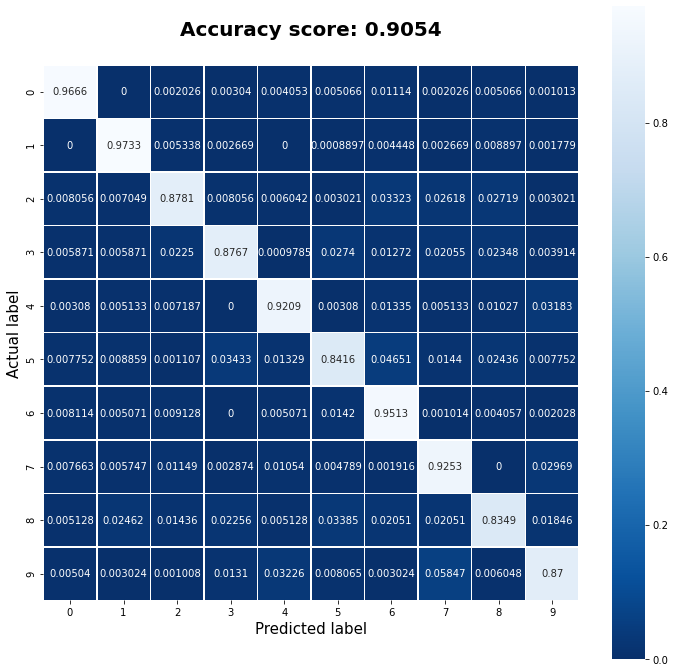

In [33]:
train_n_summary(ovr_classifiers, drop_pca1_pipeline, X_train, y_train_preprocessed, X_val, y_val)

## Optimize

### Deskewing
- Về mặt hình thức, Deskewing là quá trình làm thẳng hình ảnh đã được quét hoặc viết một cách lệch lạc – hình ảnh bị nghiêng quá xa về một hướng hoặc bị lệch.
- Người ta mô hình hóa quá trình Deskewing như một phép biến đổi affine (là một phép biến đổi gồm một biến đổi tuyến tính và một vector dịch – phép tịnh tiến).


In [34]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [35]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [36]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

In [37]:
class Deskewer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return deskewAll(X)

In [38]:
deskewer = Deskewer()

### Standard Scaler

In [39]:
scaler = StandardScaler()

### PolynomialFeatures

In [40]:
poly = PolynomialFeatures(interaction_only=True)

### Multi zoning system

In [41]:
def multi_zoning_system(X):
    tmp = X.reshape(-1,28,28)[:,2:-2,2:-2]
    system = [(8,8)]
    n = len(tmp[0])
    num_feat = sum((x[0]*x[1] for x in system))
    F = np.empty((len(tmp), num_feat))
    feat_cnt = 0
    for tup in system:
        rows = np.arange(n+1,step=n//tup[0])
        cols = np.arange(n+1,step=n//tup[1]) 
        for i in range(1,len(rows)):
            for j in range(1,len(cols)):
                F[:,feat_cnt] = (tmp[:,rows[i-1]:rows[i],cols[j-1]:cols[j]]).mean(axis=(1,2))
                feat_cnt += 1
    return F

In [42]:
multi_zoner = FunctionTransformer(multi_zoning_system)

## Experiment 2

In [43]:
deskew_drop_scale_pca_pipeline = Pipeline([('deskewer', deskewer), ('dropper', meanless_pixels_dropper),\
                                       ('pca', pca1),('scaler', scaler)])

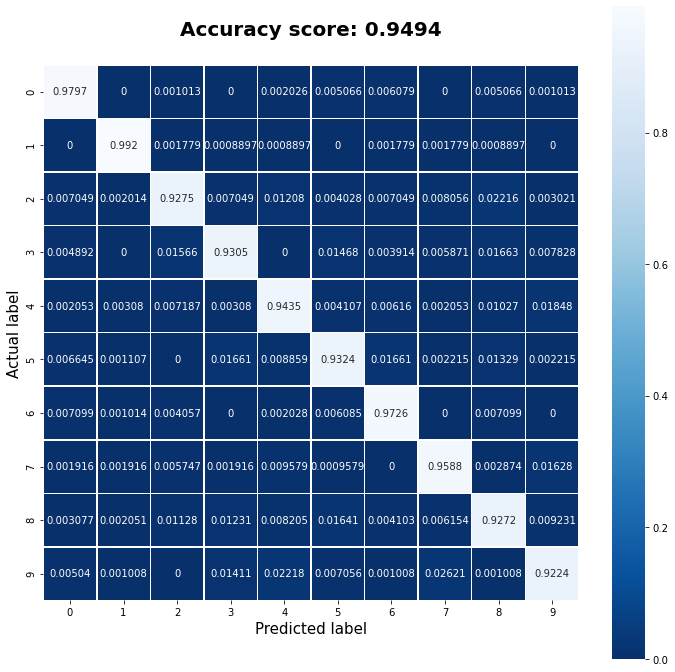

In [44]:
train_n_summary(ovr_classifiers, deskew_drop_scale_pca_pipeline, X_train, y_train_preprocessed, X_val, y_val)

## Experiment 3

In [45]:
deskew_zone_poly_scale_pipeline = Pipeline([('deskewer', deskewer), \
                                       ('zoner', multi_zoner), \
                                       ('polyfeats', PolynomialFeatures(interaction_only=True)), \
                                       ('scaler', scaler)])

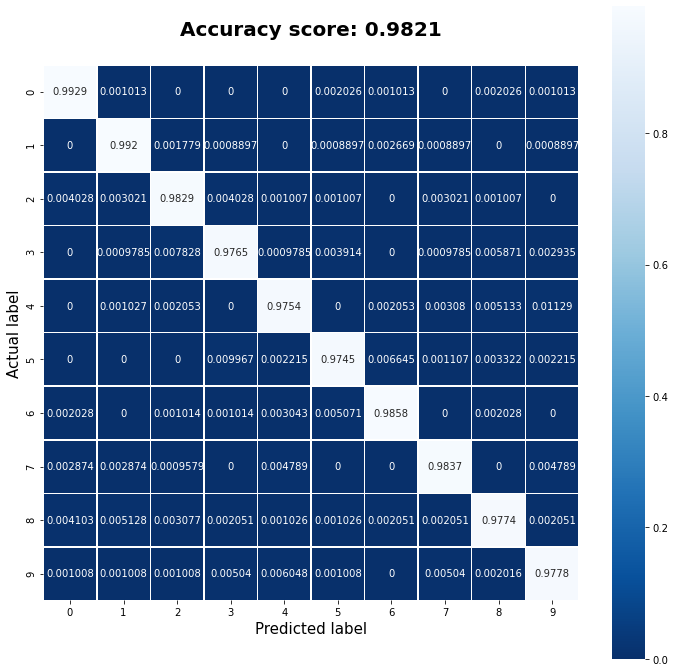

In [46]:
train_n_summary(ovr_classifiers, deskew_zone_poly_scale_pipeline, X_train, y_train_preprocessed, X_val, y_val)

## Experiment 4

In [47]:
deskew_pca_poly_scale_pipeline = Pipeline([('deskewer',deskewer),\
                                           ('pca',pca2),\
                                           ('polyfeats',poly),\
                                           ('scaler',scaler)])

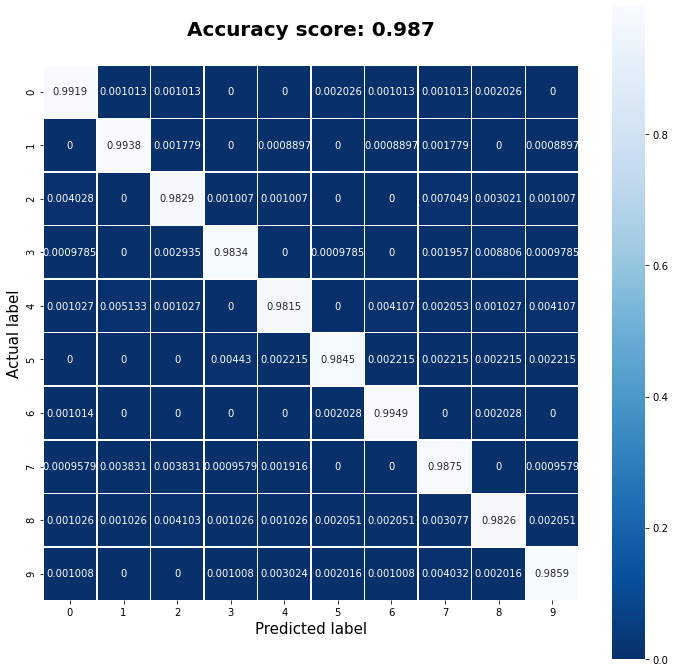

In [48]:
train_n_summary(ovr_classifiers, deskew_pca_poly_scale_pipeline, X_train, y_train_preprocessed, X_val, y_val)

## Experiment 5

In [49]:
ovo_classifiers = OneVsOneClassifier(LogisticRegression())

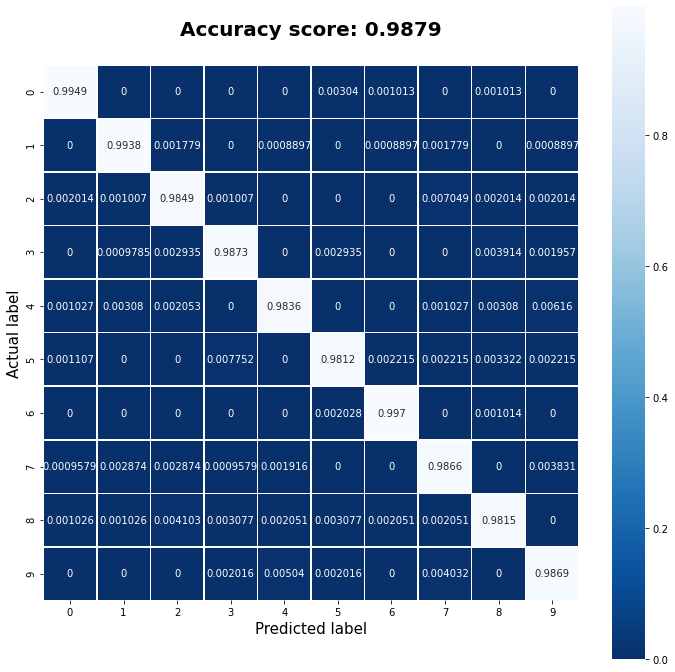

In [50]:
ovo_train_n_summary(ovo_classifiers,deskew_pca_poly_scale_pipeline, X_train, y_train, X_val, y_val)

## Prediction

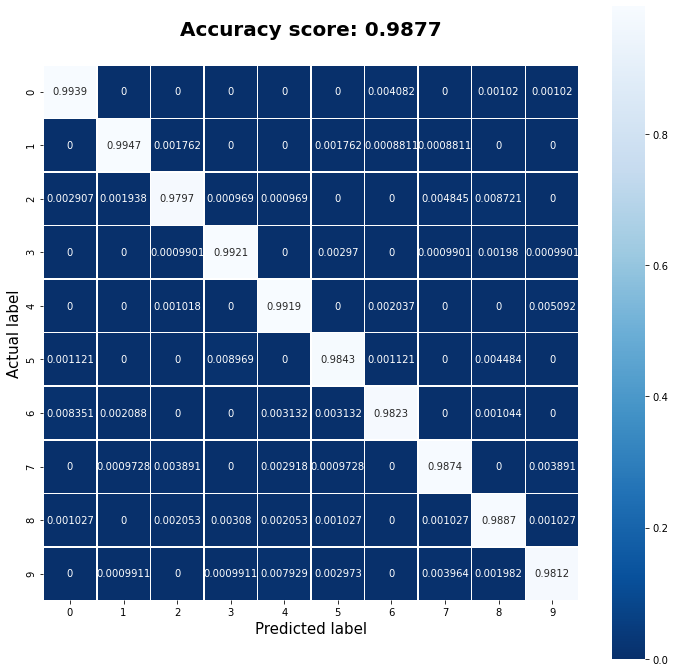

In [51]:
ovo_train_n_summary(ovo_classifiers, deskew_pca_poly_scale_pipeline, X, y, X_test, y_test)

# Predict a handwritten digit

In [52]:
selected_pipeline = deskew_pca_poly_scale_pipeline
ovo_train(ovo_classifiers, selected_pipeline, pixel_cols.reshape(-1,28,28), label_col)

In [53]:
def event_function(event):
    x = event.x
    y = event.y
    
    x1 = x - 16
    y1 = y - 16
    
    x2 = x + 16
    y2 = y + 16
    
    canvas.create_oval((x1,y1,x2,y2), fill = 'black')
    img_draw.ellipse((x1,y1,x2,y2), fill = 'white')

def clear():
    global img, img_draw, label_status
    
    img = Image.new('RGB',(500, 500),(0,0,0))
    img_draw = ImageDraw.Draw(img)
    canvas.delete('all')
    label_status.config(text = 'Waiting...')


def predict():
    global label_status
    img_array = np.array(img)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    img_array = cv2.resize(img_array, (28,28))
    img_array = img_array.reshape(784,) 

    result = ovo_predictions(ovo_classifiers, selected_pipeline.transform(img_array.reshape(1,-1)))
    label_status.config(text = ('PREDICTION: ' + str(result[0])))


count = 0
win = tk.Tk()
canvas = tk.Canvas(win, width = 500, heigh = 500, bg = 'white')
canvas.grid(row = 0 , column = 0, columnspan = 4)

button_predict = tk.Button(win, text = 'PREDICT', bg = 'gray', fg = 'white', font = 'Helvetica 20 bold',command =  predict)
button_predict.grid(row = 1, column = 1)

button_clear = tk.Button(win, text = 'CLEAR', bg = 'gray', fg = 'white', font = 'Helvetica 20 bold', command = clear)
button_clear.grid(row = 1, column = 2)

button_exit = tk.Button(win, text = 'EXIT', bg = 'gray', fg = 'white', font = 'Helvetica 20 bold', command = win.destroy)
button_exit.grid(row = 1, column = 3)

label_status = tk.Label(win, text = 'PREDICTION', bg = 'gray', fg = 'white', font = 'Helvetica 20 bold')
label_status.grid(row = 2, column = 0, columnspan = 4)

canvas.bind('<B1-Motion>', event_function)
img = Image.new('RGB',(500, 500),(0,0,0))
img_draw = ImageDraw.Draw(img)
win.mainloop()

# Accuracy trên train, test, extra_test

## Accuracy trên train

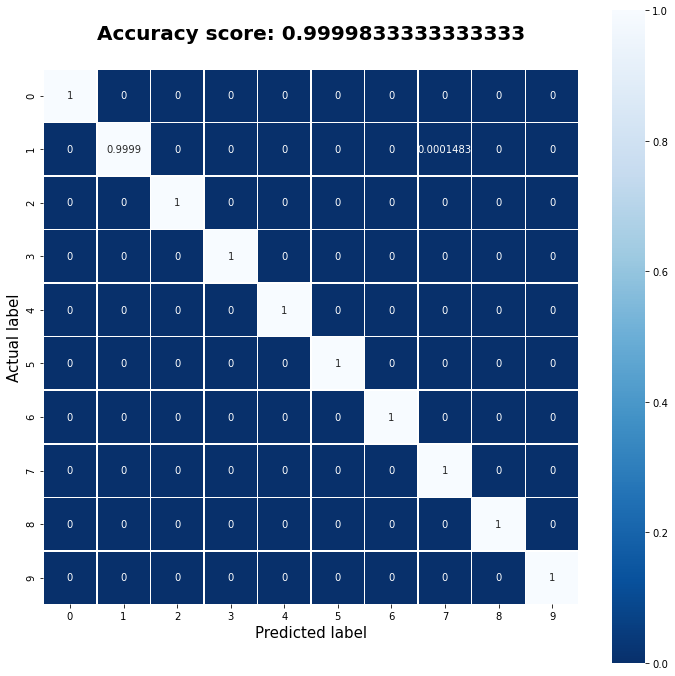

In [54]:
ovo_train_n_summary(ovo_classifiers, deskew_pca_poly_scale_pipeline, X, y, X, y)

## Accuracy trên test

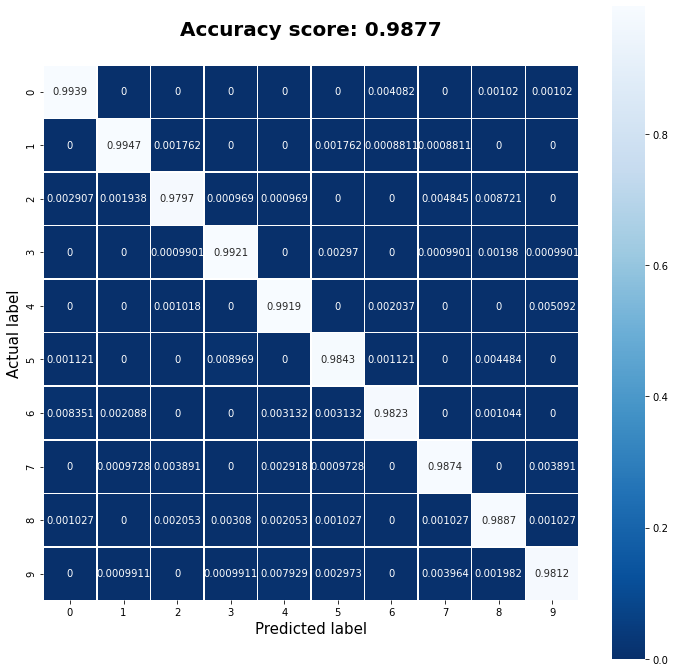

In [55]:
ovo_train_n_summary(ovo_classifiers, deskew_pca_poly_scale_pipeline, X, y, X_test, y_test)

## Accuracy trên extra_test

In [56]:
extra_test = pd.read_csv('newtest.csv', header = None, index_col = 784)
extra_test

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
784,,,,,,,,,,,,,,,,,,,,,
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


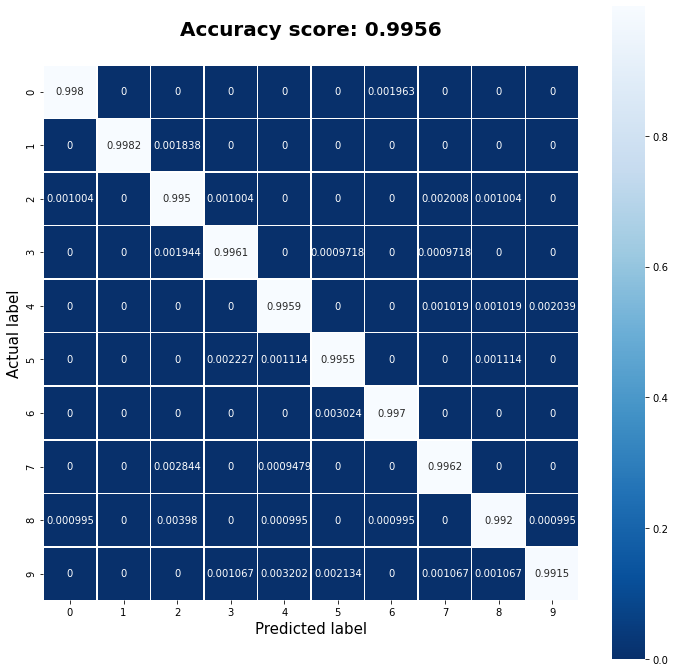

In [57]:
ovo_train_n_summary(ovo_classifiers, deskew_pca_poly_scale_pipeline, X, y,extra_test.values, extra_test.index)